# ChIP-seq ETS1 transcription factor in NK cells

In this notebook, the ChIP-seq analysis is carried out to learn more about ETS1 transcription factor in natural killer cells (NK cell) in human, based on paper ***The transcription factor ETS1 is an important regulator of human NK cell development and terminal differentiation*** ([Sylvie Taveirne et al](https://doi.org/10.1182/blood.2020005204)). The datasets are taken from GEO database with the accession number [GSE124103](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE124103). The NK cells were isolated from the peripheral blood mononuclear cells. The datasets involve 1 fastq file of fragments that were percipitated with anti-ETS1 in NK cells, and 1 fastq file of the ones without ETS1 antigen as input.

# Outline

1. [Introduction](#intro)

    
2. [Data analysis](#data)
    
    Each step will briefly describe the analysis approach and explain the result of the code, followed by the `code cells`.
    1. [Parsing the dataset](#subdata1)
    2. [FASTQ quality control](#subdata2)
        1. NK_ETS1 data quality score
        2. NK_input data quality score
            
    3. [Alignment of ETS1 ChIP-seq reads](#alignment)
        1. NK_ETS1 data
        2. NK_input data
    4. [Checking BAM files in IGV](#igv)
        1. [NK_ETS1 data](#igv1)
        2. [NK_ETS1 vs input data](#igv2)
    5. [Genome-wide coverage](#coverage)
        1. [IGV visualization](#visual)
    6. [Peak calling](#peak)
        1. [Heatmap plot](#heatmap)
    7. [Motif analysis](#motifs)
        1. [De novo motifs analysis](#denovo)
        2. [Direct peaks](#direct)
        3. [PWM and track enrichment](#track)
    8. [Link peaks to gene](#link)
    9. [Comparison of predicted targets with functional associations to ETS1](#ets1)
3. [Conclusion](#conclusion)

# Introduction <a name="intro"></a>

Natural killer (NK) cells plays a crucial role in secreting cytokine to defense against tumor cells and pathogens, and regulate other immune cells. Transcription factor ETS1 is known to directly controls the expression of cytokine and chemokine genes ([UniProt](https://www.uniprot.org/uniprotkb/P14921/entry)), especially in T cells and B cells. Thus, it is interesting to investigates the impact of ETS1 in NK cells. In fact, in the literature mentioned above, ETS1 directly induces expression of other TFs that contributes to NK cell differentiation and regulates genes that involve in cell activation and apotosis.

# Data analysis <a name="data"></a>

## Parsing the dataset <a name="subdata1"></a>

The fastq files are then renamed (manually) for further analysis.

In [1]:
mkdir -p /mnt/storage/$USER/jupyternotebooks/chipSeq/
cd /mnt/storage/$USER/jupyternotebooks/chipSeq/

In [2]:
fastq-dump -O /mnt/storage/$USER/jupyternotebooks/chipSeq/Data_ETS1/ SRR8353379

Read 34026810 spots for SRR8353379
Written 34026810 spots for SRR8353379


In [5]:
fastq-dump -O /mnt/storage/$USER/jupyternotebooks/chipSeq/Data_ETS1/ SRR8353380

Read 36387388 spots for SRR8353380
Written 36387388 spots for SRR8353380


In [6]:
fastqc Data_ETS1/ChIP_ets1_NKcells.fastq

Started analysis of ChIP_ets1_NKcells.fastq
Approx 5% complete for ChIP_ets1_NKcells.fastq
Approx 10% complete for ChIP_ets1_NKcells.fastq
Approx 15% complete for ChIP_ets1_NKcells.fastq
Approx 20% complete for ChIP_ets1_NKcells.fastq
Approx 25% complete for ChIP_ets1_NKcells.fastq
Approx 30% complete for ChIP_ets1_NKcells.fastq
Approx 35% complete for ChIP_ets1_NKcells.fastq
Approx 40% complete for ChIP_ets1_NKcells.fastq
Approx 45% complete for ChIP_ets1_NKcells.fastq
Approx 50% complete for ChIP_ets1_NKcells.fastq
Approx 55% complete for ChIP_ets1_NKcells.fastq
Approx 60% complete for ChIP_ets1_NKcells.fastq
Approx 65% complete for ChIP_ets1_NKcells.fastq
Approx 70% complete for ChIP_ets1_NKcells.fastq
Approx 75% complete for ChIP_ets1_NKcells.fastq
Approx 80% complete for ChIP_ets1_NKcells.fastq
Approx 85% complete for ChIP_ets1_NKcells.fastq
Approx 90% complete for ChIP_ets1_NKcells.fastq
Approx 95% complete for ChIP_ets1_NKcells.fastq
Analysis complete for ChIP_ets1_NKcells.fastq

In [11]:
fastqc Data_ETS1/ChIP_input_NKcells.fastq

Started analysis of ChIP_input_NKcells.fastq
Approx 5% complete for ChIP_input_NKcells.fastq
Approx 10% complete for ChIP_input_NKcells.fastq
Approx 15% complete for ChIP_input_NKcells.fastq
Approx 20% complete for ChIP_input_NKcells.fastq
Approx 25% complete for ChIP_input_NKcells.fastq
Approx 30% complete for ChIP_input_NKcells.fastq
Approx 35% complete for ChIP_input_NKcells.fastq
Approx 40% complete for ChIP_input_NKcells.fastq
Approx 45% complete for ChIP_input_NKcells.fastq
Approx 50% complete for ChIP_input_NKcells.fastq
Approx 55% complete for ChIP_input_NKcells.fastq
Approx 60% complete for ChIP_input_NKcells.fastq
Approx 65% complete for ChIP_input_NKcells.fastq
Approx 70% complete for ChIP_input_NKcells.fastq
Approx 75% complete for ChIP_input_NKcells.fastq
Approx 80% complete for ChIP_input_NKcells.fastq
Approx 85% complete for ChIP_input_NKcells.fastq
Approx 90% complete for ChIP_input_NKcells.fastq
Approx 95% complete for ChIP_input_NKcells.fastq
Analysis complete for ChI

In [34]:
wc -l ./Data_ETS1/ChIP_ets1_NKcells.fastq

136107240 ./Data_ETS1/ChIP_ets1_NKcells.fastq


In [35]:
wc -l ./Data_ETS1/ChIP_input_NKcells.fastq

145549552 ./Data_ETS1/ChIP_input_NKcells.fastq


## FASTQ quality control <a name="subdata2"></a>

The NK_ETS1 dataset has roughly 34 millions reads and the input file has around 36 millions reads. The quality score of both NK_ETS1 and NK_input datasets are quite good. There are slightly drops in signal at the end, which is due to signal decay or phasing, but no pertubing signal. The overrepresented sequences does not take up more than 3% so we can continue analysing these datasets.

**NK_ETS1 data quality score**:

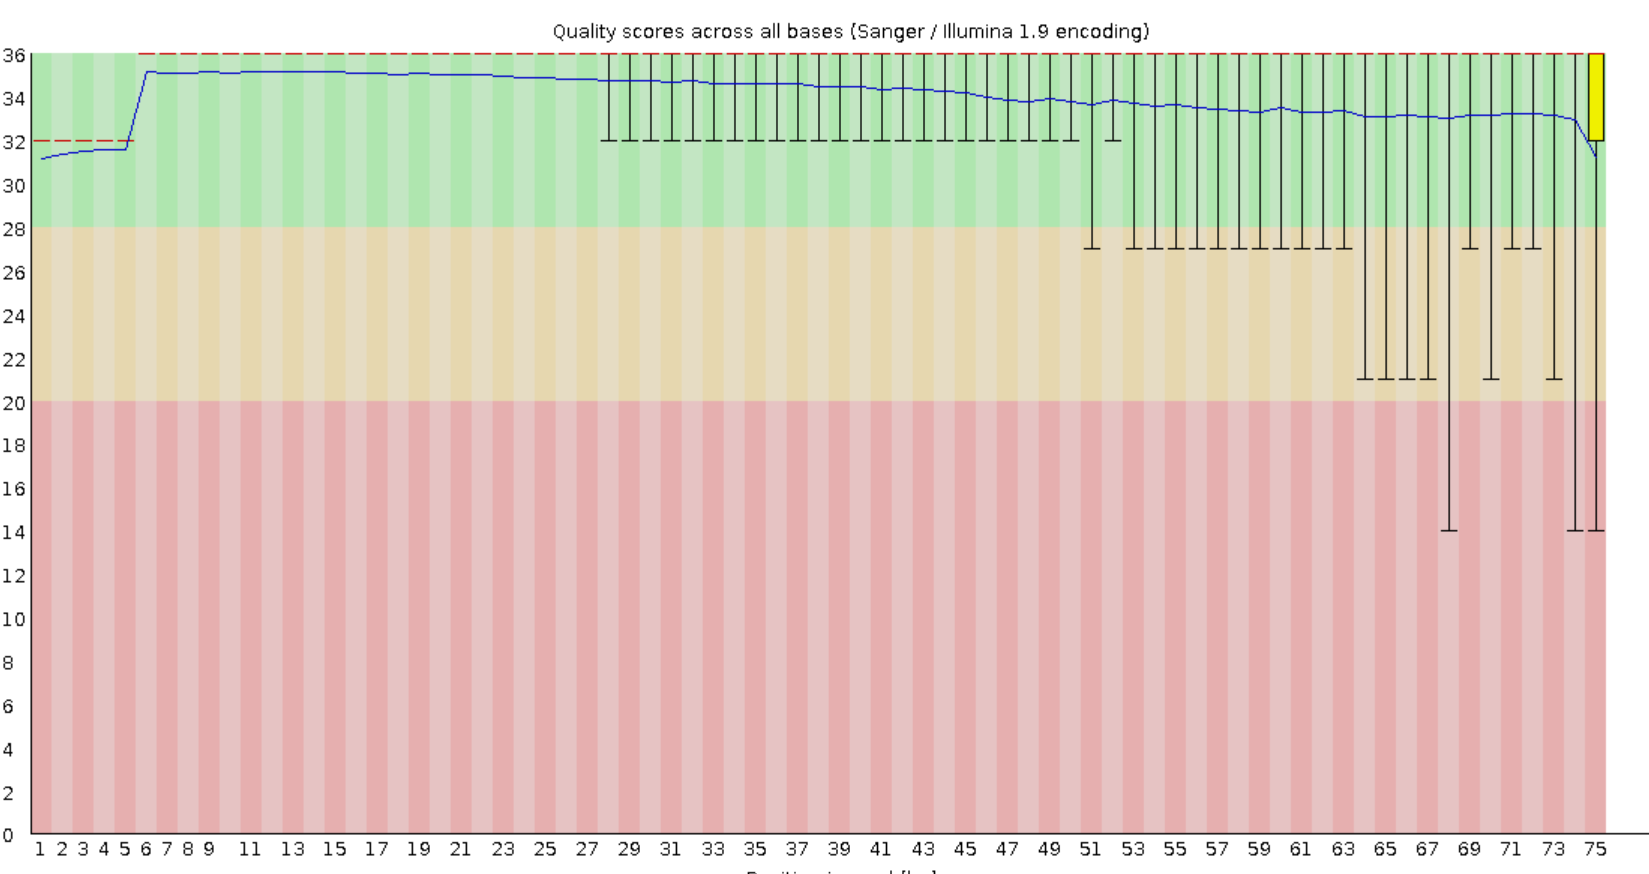

**NK_ETS1 data quality score:**

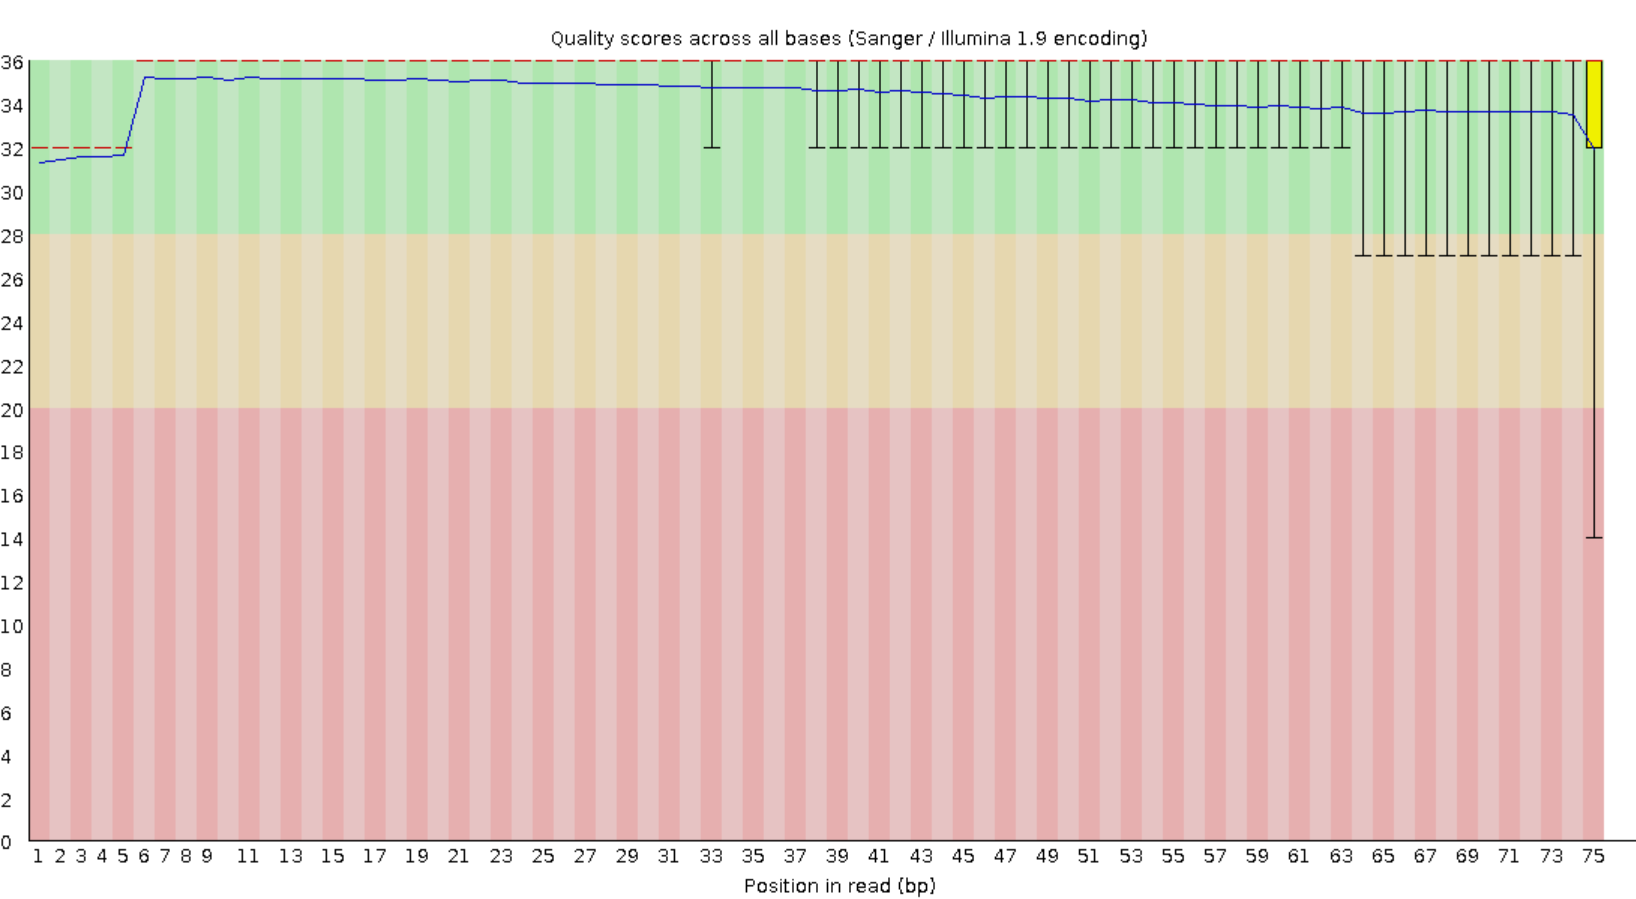

## Alignment of ETS1 and input ChIP-seq reads <a name="alignment"></a>

`bowtie2` is used to aligned the two datasets to hg38 human genome assembly. Both datasets have good alignment rate of over 90%. Around 31 millions reads were mapped to the genome out of 34 millions of total reads in NK_ETS1 dataset. For input dataset, all 36 millions reads are mapped to the hg38 genome.

### NK_ETS1 data

In [12]:
bowtie2 -x /mnt/storage/data/resources/hg38/hg38 Data_ETS1/ChIP_ets1_NKcells.fastq -S ChIP_ets1.sam

34026810 reads; of these:
  34026810 (100.00%) were unpaired; of these:
    2853602 (8.39%) aligned 0 times
    21844771 (64.20%) aligned exactly 1 time
    9328437 (27.41%) aligned >1 times
91.61% overall alignment rate


In [13]:
samtools view -S -b ChIP_ets1.sam > ChIP_ets1.bam

In [14]:
rm ChIP_ets1.sam

In [17]:
# Number of mapped reads.
samtools view -c -F 260 ChIP_ets1.bam

31173208


In [18]:
samtools sort -O bam -o ChIP_ets1.sorted.bam ChIP_ets1.bam

[bam_sort_core] merging from 10 files and 1 in-memory blocks...


In [19]:
samtools index ChIP_ets1.sorted.bam

### NK_input data

In [20]:
bowtie2 -x /mnt/storage/data/resources/hg38/hg38 Data_ETS1/ChIP_input_NKcells.fastq -S ChIP_input.sam

36387388 reads; of these:
  36387388 (100.00%) were unpaired; of these:
    1881756 (5.17%) aligned 0 times
    24157646 (66.39%) aligned exactly 1 time
    10347986 (28.44%) aligned >1 times
94.83% overall alignment rate


In [21]:
samtools view -S -b ChIP_input.sam > ChIP_input.bam

In [22]:
rm ChIP_input.sam

In [23]:
samtools sort -O bam -o ChIP_input.sorted.bam ChIP_input.bam

[bam_sort_core] merging from 10 files and 1 in-memory blocks...


In [24]:
samtools index ChIP_input.sorted.bam

In [25]:
samtools view -c ChIP_input.bam

36387388


## Checking BAM files in IGV <a name="igv"></a>

### NK_ETS1 data <a name="igv1"></a>

Enrichments of reads can be visualized on IGV. In the figure below, enrichment for NK_ETS1 data can be found. For example of TLN1 gene on chromosome 9, the peaks in black box, which lies at the promoter, is considered as peak in the alignment, since it contains many different fragments which could come from different cells. The peaks in the green boxes consists of many same fragments that minght be just PCR duplicates, thus, are not considered as peaks.

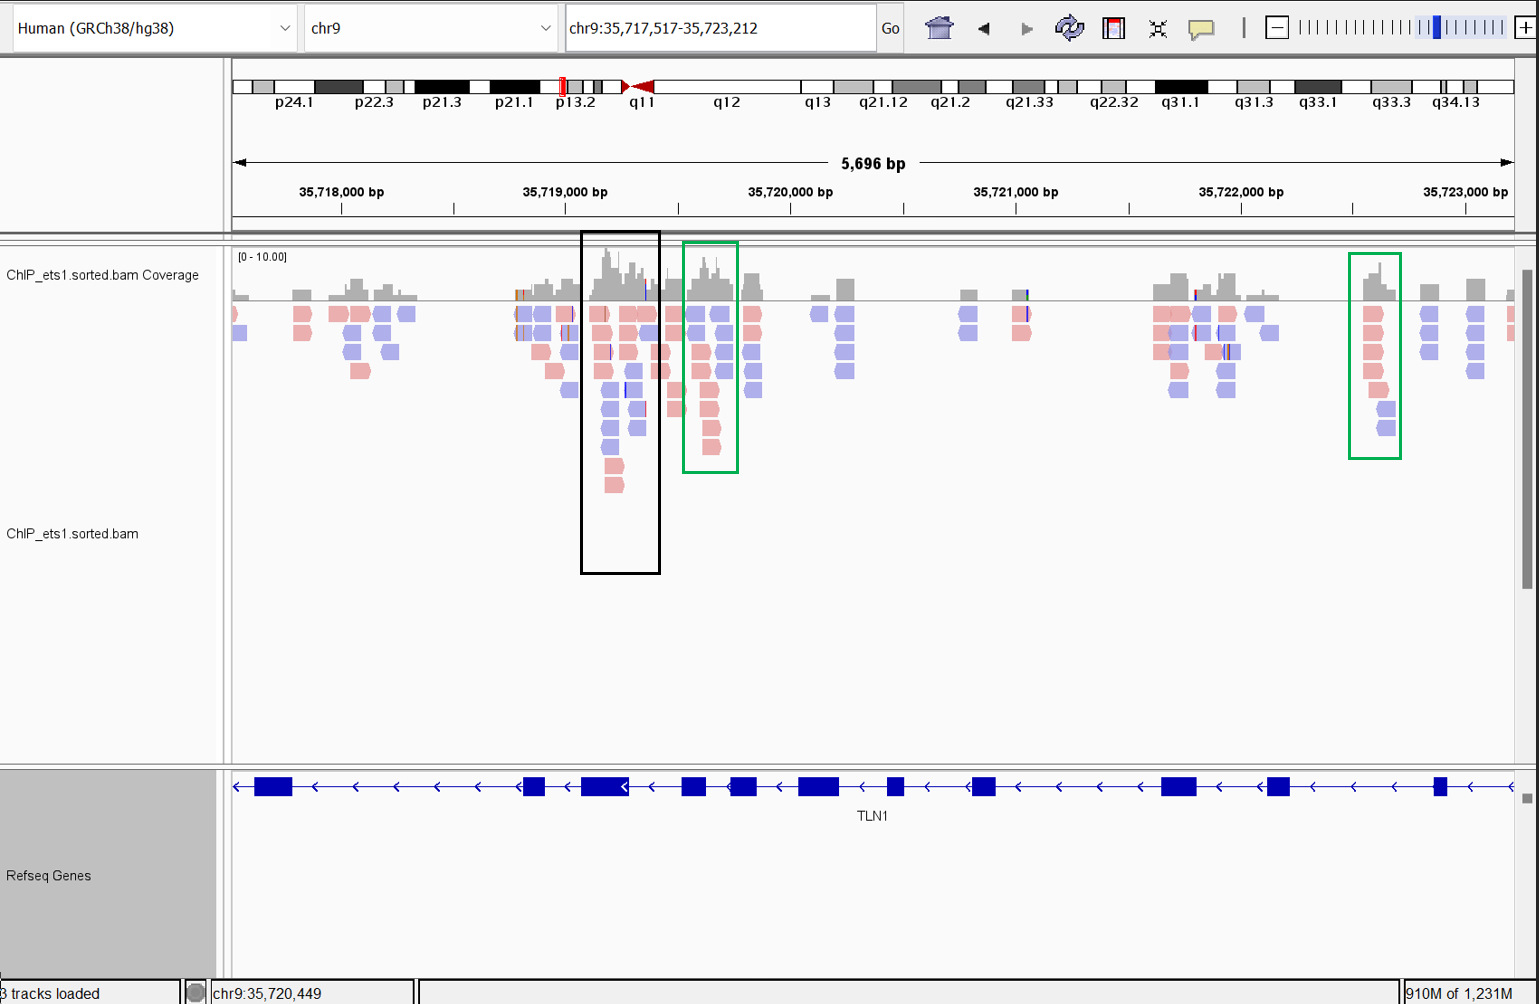


### NK_ETS1 vs input data <a name="igv2"></a>

Comparing the two ETS1 data and the input data on IGV, for example of SPAG8 and HINT2 genes on chr9, there are peaks in the ETS1 bam file, but there is little signal in the input file. This indicates that the peaks are not from any artifacts in the genome but from the antigen ETS1 that percipitated the fragments of the peaks.

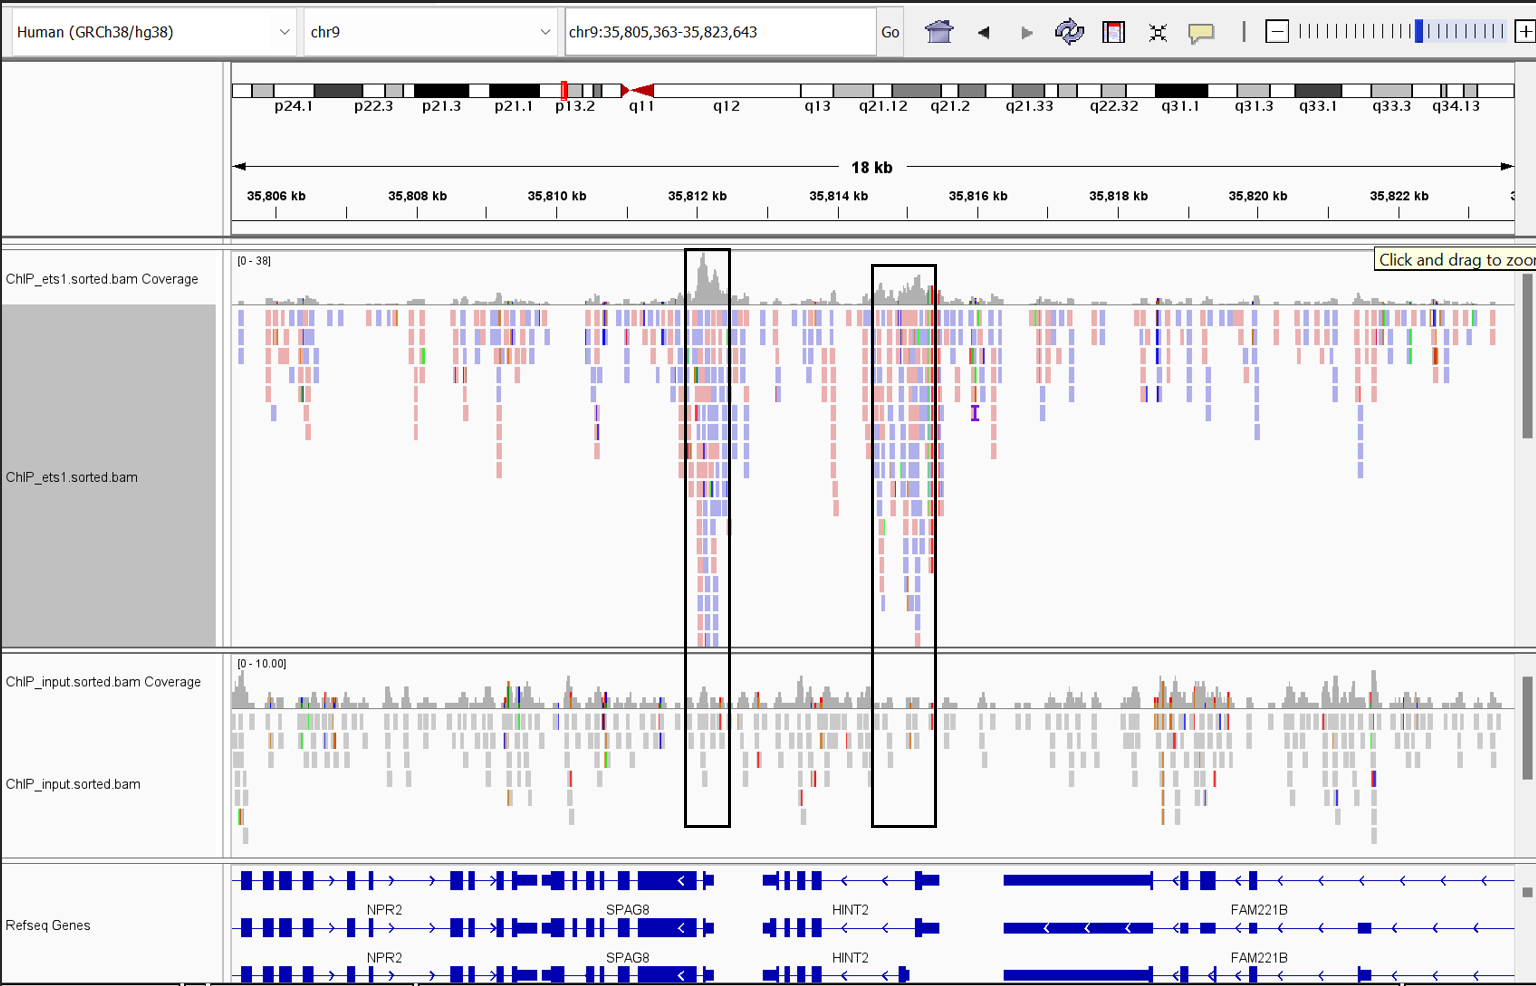

## Genome-wide coverage <a name="coverage"></a>

BigWig file can be computed to clearly observe te coverage of peaks of the ETS1 datasets on IGV. BigWig file is created using `bamCoverage` algorithm, based on genome size of hg38 which is 2913022398 bp based on [deeptools API](https://deeptools.readthedocs.io/en/latest/content/feature/effectiveGenomeSize.html), and bin size (steps) of 5.

In [26]:
# Bin size of 5
bamCoverage -b ChIP_ets1.sorted.bam --normalizeUsing RPGC --effectiveGenomeSize 2913022398 -o ETS1.bw -bs 5

normalization: 1x (effective genome size 2913022398)
bamFilesList: ['ChIP_ets1.sorted.bam']
binLength: 5
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
defaultFragmentLength: read length
numberOfProcessors: 1
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 5
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 1000


### IGV visualization <a name="visual"></a>

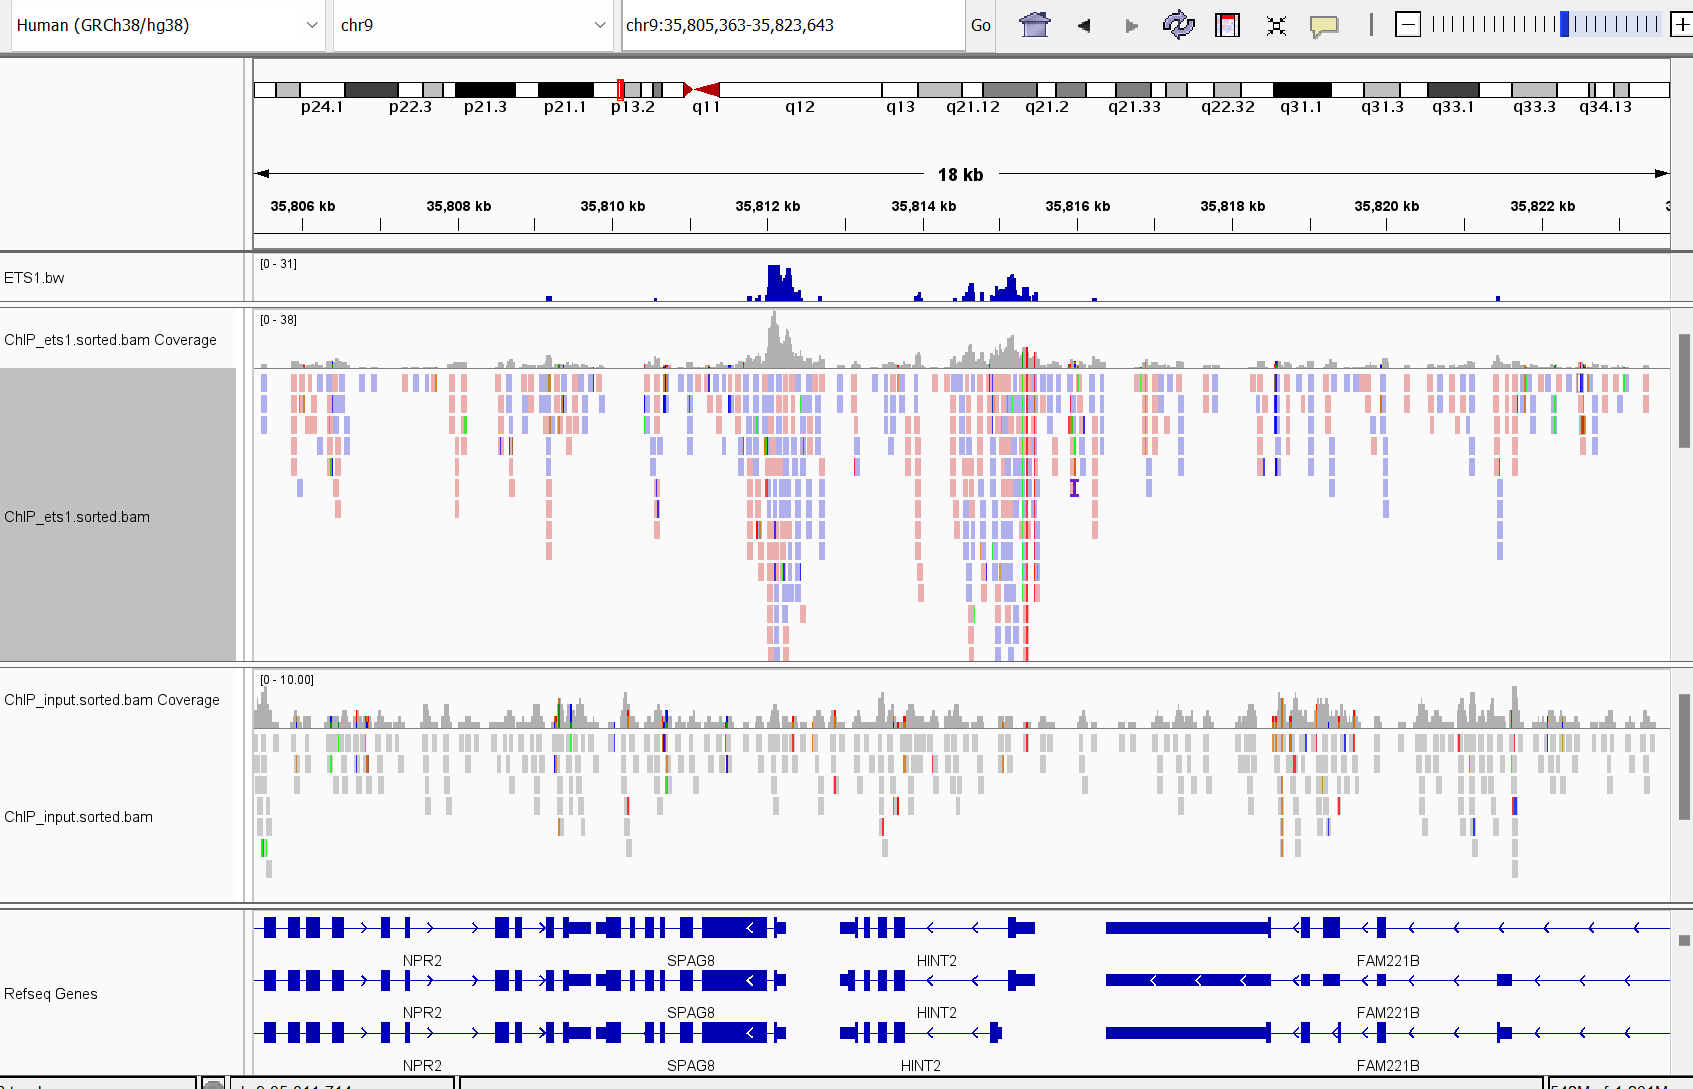

## Peak calling <a name="peak"></a>

`macs2` algorithm is used to determine and locate peaks in the datasets, with size of human genome (as in `bamCoverage` algorithm) and a cut-off of 0.05. There are around 20,500 peaks were found in the dataset. Based on q-value scores, top 1000 peaks can be retrieved. Heatmap plot of the peaks is computed to double check to quality of chIP-seq data, based on the reference of the peak itself, after converting the narrowPeak file to bed format.

In [27]:
macs2 callpeak -t ChIP_ets1.sorted.bam -c ChIP_input.sorted.bam -n ets1 -g 2913022398 -q 0.05

INFO  @ Fri, 05 Jan 2024 23:10:47: 
# Command line: callpeak -t ChIP_ets1.sorted.bam -c ChIP_input.sorted.bam -n ets1 -g 2913022398 -q 0.05
# ARGUMENTS LIST:
# name = ets1
# format = AUTO
# ChIP-seq file = ['ChIP_ets1.sorted.bam']
# control file = ['ChIP_input.sorted.bam']
# effective genome size = 2.91e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 1000 bps and 10000 bps
# Broad region calling is off
# Paired-End mode is off
 
INFO  @ Fri, 05 Jan 2024 23:10:47: #1 read tag files... 
INFO  @ Fri, 05 Jan 2024 23:10:47: #1 read treatment tags... 
INFO  @ Fri, 05 Jan 2024 23:10:47: Detected format is: BAM 
INFO  @ Fri, 05 Jan 2024 23:10:47: * Input file is gzipped. 
INFO  @ Fri, 05 Jan 2024 23:10:52:  

In [28]:
cat ets1_peaks.narrowPeak | wc -l

20562


In [29]:
cat ets1_peaks.narrowPeak | sort -k9 -g -r | head -1000

chr1	228486423	228487465	ets1_peak_1779	4692	.	103.03490	477.30722	469.26337	773
chr11	118435113	118436532	ets1_peak_3668	3151	.	84.01101	322.15942	315.17950	1031
chr7	158803506	158804746	ets1_peak_18356	3021	.	72.70764	309.10181	302.18103	728
chr21	8987085	8987525	ets1_peak_13017	2784	.	40.73870	285.22870	278.41882	132
chr2	10953419	10954264	ets1_peak_11151	2483	.	28.07189	255.01367	248.32631	560
chr7	100119092	100119898	ets1_peak_17975	2418	.	61.37718	248.51051	241.85736	349
chr5	96934667	96936495	ets1_peak_15790	2313	.	59.09926	237.93747	231.37373	560
chr22	41468538	41469535	ets1_peak_13635	2246	.	65.46292	231.16780	224.65675	367
chr3	12841100	12841898	ets1_peak_13938	2245	.	58.80859	231.01434	224.50461	571
chrUn_KI270467v1	797	3920	ets1_peak_20109	2237	.	66.40746	230.24811	223.74619	1345
chr22_KI270733v1_random	119526	124627	ets1_peak_13803	2191	.	12.83344	225.60674	219.17348	4903
chr1	1745089	1747291	ets1_peak_98	2122	.	57.52545	218.58215	212.29102	1182
chr3	93470292	93470870	ets1

In [30]:
cat ets1_peaks.narrowPeak | cut -f 1-3 > ets1_peaks.bed

### Heatmap plot <a name="heatmap"></a>

Heatmap are plotted with 800 bases wide on both side. As from the heatmap, the strength (height) of the peaks is not very strong, indicating a weak signal.

In [40]:
computeMatrix reference-point \
    -S ETS1.bw \
    -R ets1_peaks.bed \
    --referencePoint center \
    -a 800 \
    -b 800 \
    --binSize 5 \
    -out ets1.tab.gz

In [41]:
plotHeatmap \
    -m ets1.tab.gz \
    -out ets1.png \
    --heatmapHeight 15  \
    --refPointLabel peak.center \
    --regionsLabel peaks \
    --plotTitle 'ChIP-seq signal'

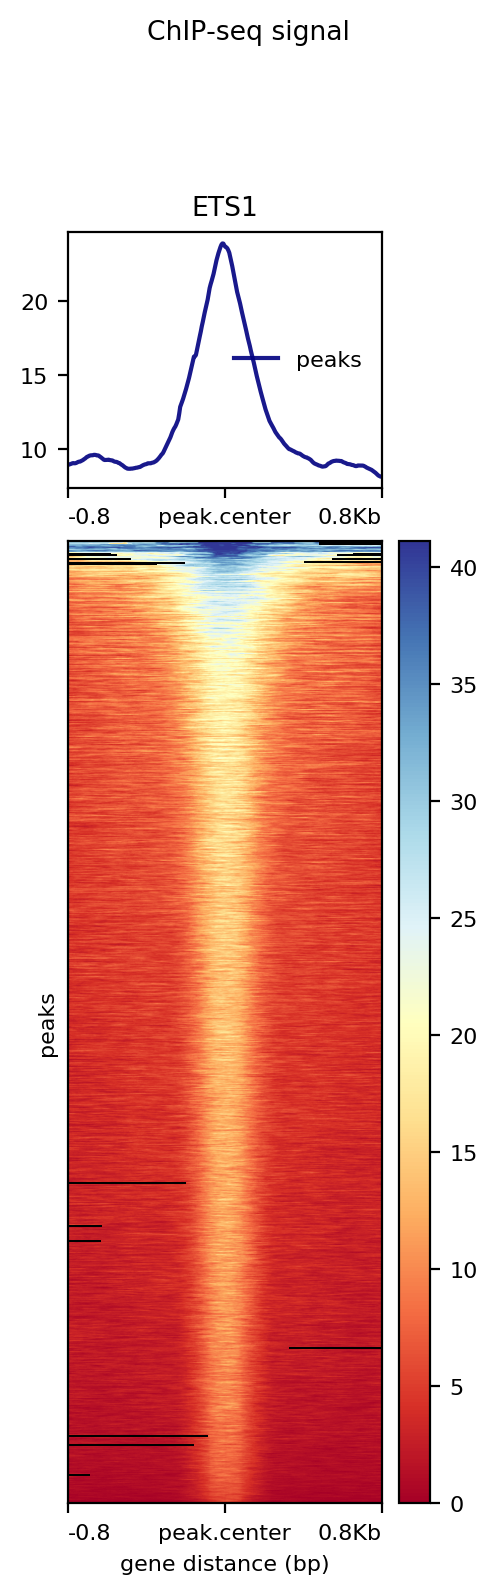

# Motif Analysis <a name="motifs"></a>

The bed files from narrowPeak data is converted into fasta file for motif analysis on RSAT tools, with a default control.

In [33]:
bedtools getfasta -fi /mnt/storage/data/resources/hg38/hg38.fa -bed ets1_peaks.bed -fo ets1_peaks.fasta

## *De novo* motif analysis <a name="denovo"></a>

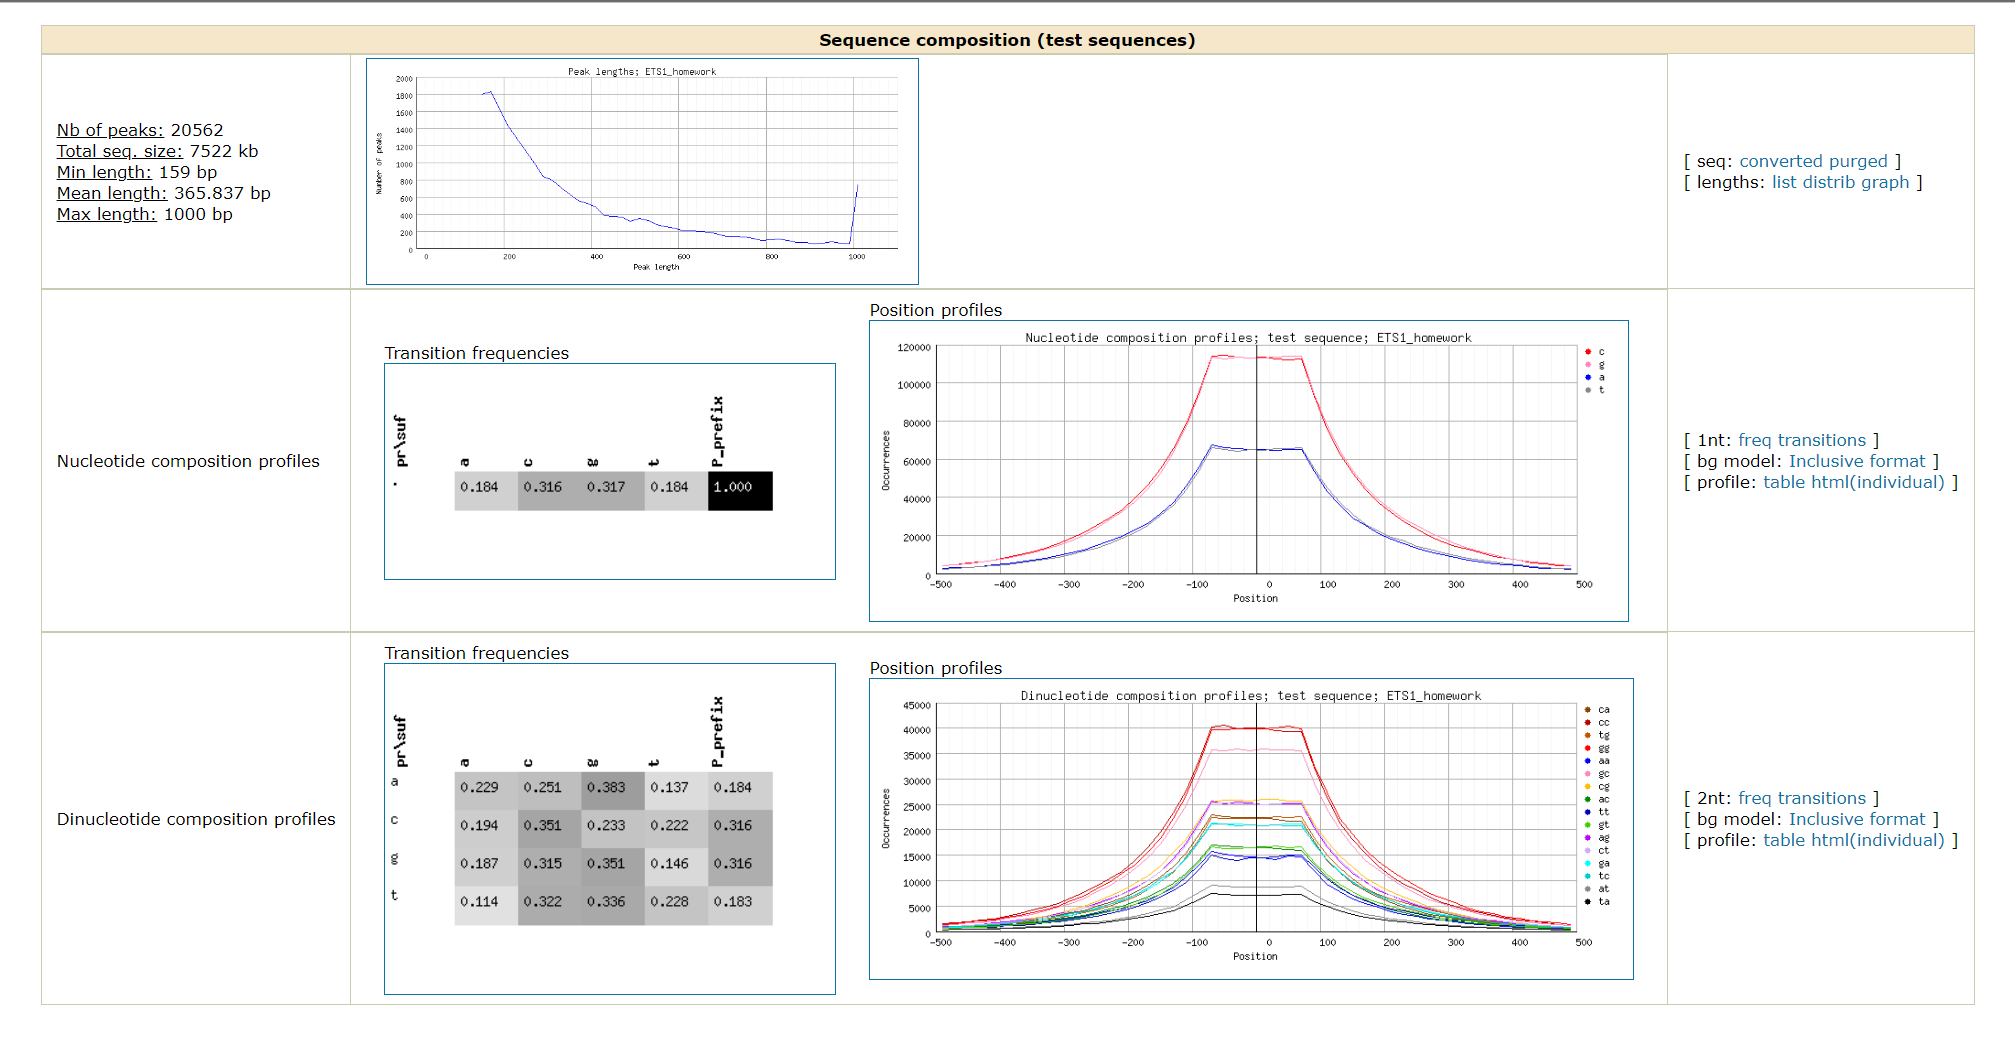

In the statistical data above, the input fasta sequence is shown to contains a lot of G and C base contents in the sequence, with around 30% G and 30% C, comparing to 10% A and 10% B. Thus, this also result into more dinucleotide combination containing C and G. 

There are 20 motifs found in the peaks motif dataset. Motif 4 is shown to take nearly 19% of all 20 500 peaks. However, motif 4 is not specific for ETS1 motifs, but for Runx motifs which is `ACCACA`. The majority of the motifs locate in the middle of the peaks, indicating these peaks are good in quality.

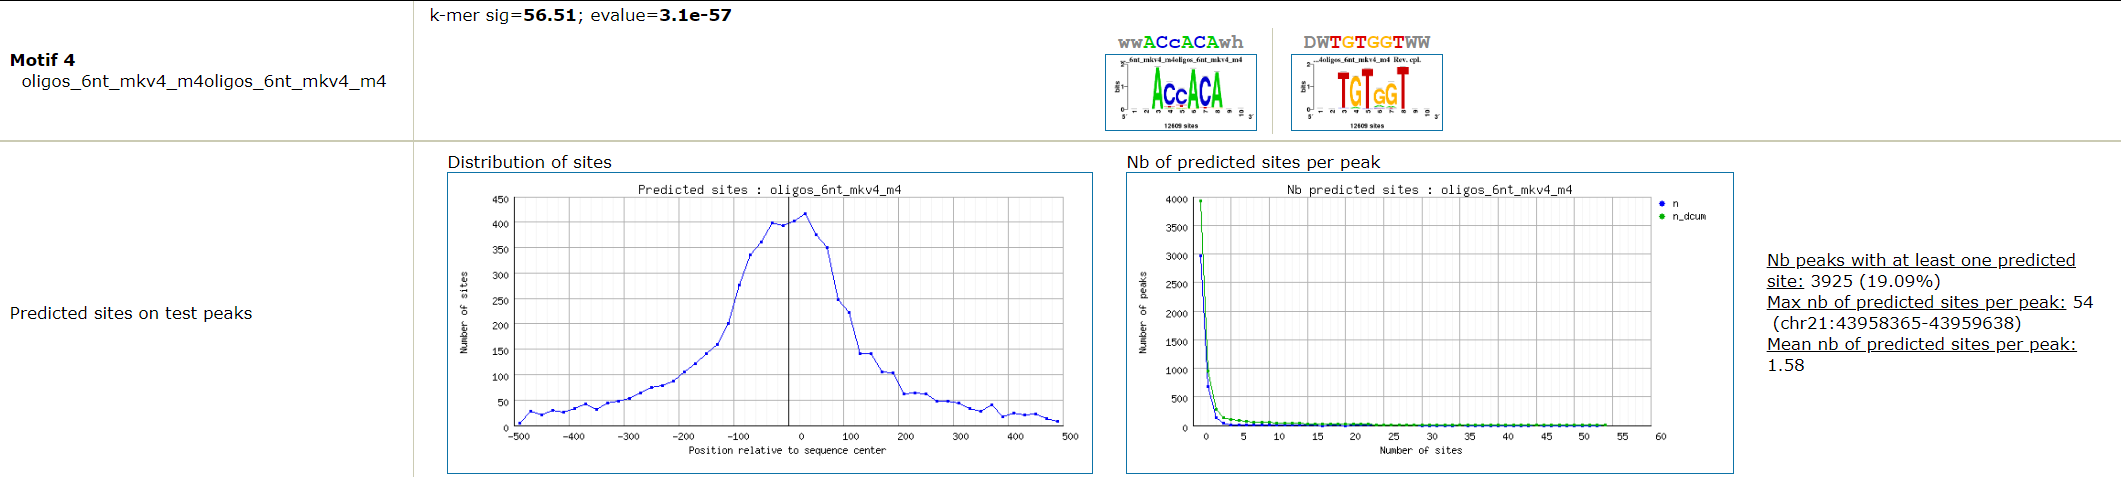

The ETS1 motif, which is usually `AGGAAGT`, is found in motif 17. Some other motifs also shown a sequence of `CGGAAGGT`, like motif 7, 13, 18. In this case, we will focus in motif 17, which take around 16% of all peaks (3411 over 20 500 peaks). The distribution of the motifs is also at center, indicating peaks containing this motif are in good quality.

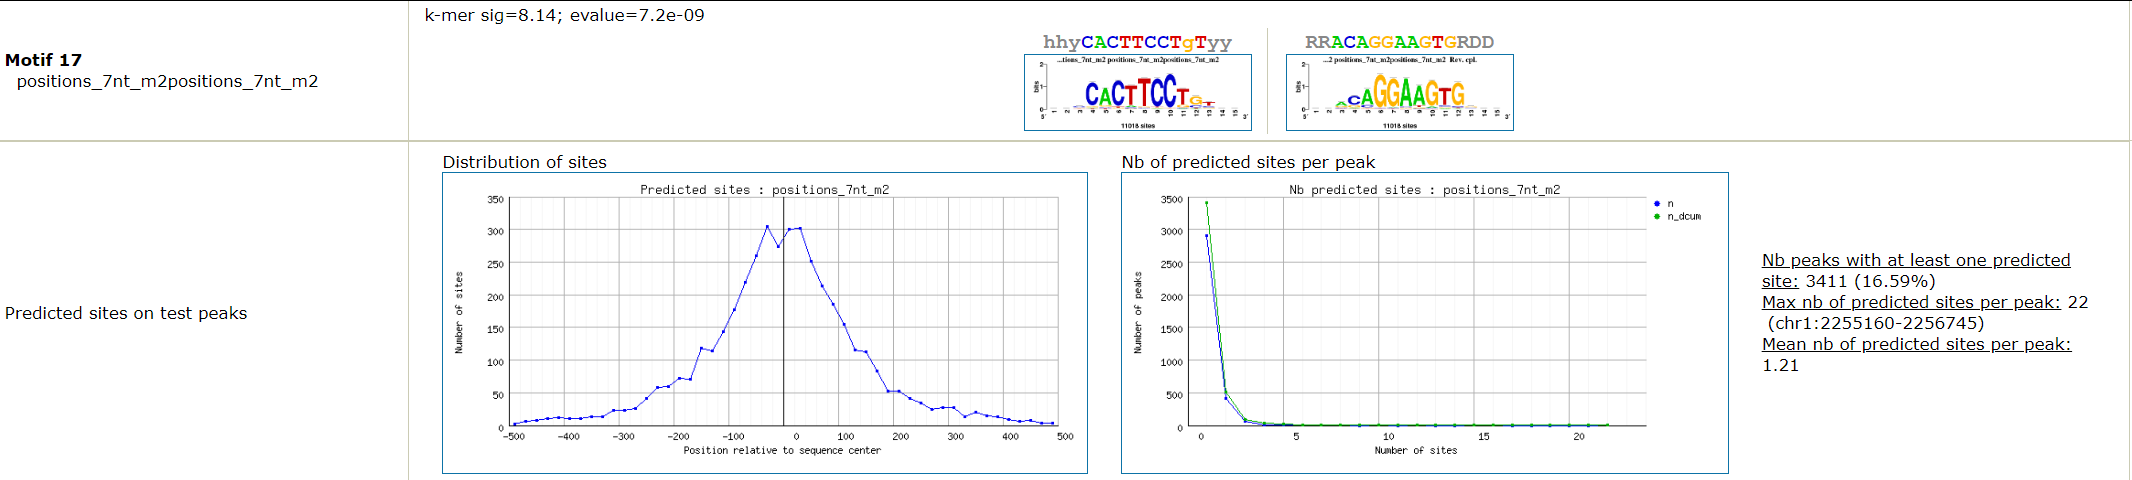

Image of motif 17, `CGGAAGGT`:

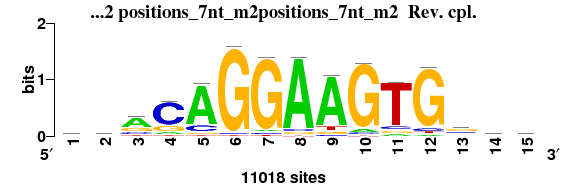

## Direct peaks <a name="direct"></a>

In [42]:
cat peak-motifs_17.tab | grep -v ";" | grep -v '#' | head

chr1:629045-630071	site	positions_7nt_m2positions_7nt_m2	D	-227	-213	ATACACCTCCTATGA	7.7
chr1:631861-632334	site	positions_7nt_m2positions_7nt_m2	D	99	113	GCCCACTTCCACTAT	8.1
chr1:827050-828002	site	positions_7nt_m2positions_7nt_m2	D	233	247	CCCAACTTCCTGTTA	9.5
chr1:940748-941187	site	positions_7nt_m2positions_7nt_m2	D	-28	-14	CGACACTTCCTCGCC	8.9
chr1:940748-941187	site	positions_7nt_m2positions_7nt_m2	R	190	204	CGCCACCTCCTGCCG	7.5
chr1:959045-959385	site	positions_7nt_m2positions_7nt_m2	D	46	60	CCCCACTTCCGGCCC	8.2
chr1:965731-965908	site	positions_7nt_m2positions_7nt_m2	D	50	64	GTGCAGTTCCTGTGG	7.6
chr1:1166193-1166376	site	positions_7nt_m2positions_7nt_m2	D	59	73	GCCCACTTCCTCCTG	8.1
chr1:1212689-1213801	site	positions_7nt_m2positions_7nt_m2	D	-160	-146	TCCCACTTCCTGAGC	9.5
chr1:1218784-1218985	site	positions_7nt_m2positions_7nt_m2	D	29	43	CAGGACTTCCTGTGC	8.2
grep: write error: Broken pipe
grep: write error: Broken pipe
cat: write error: Broken pipe


In [65]:
cat peak-motifs_17.tab | grep -v ";" | grep -v '#' | cut -f 1 |sed 's/:/\t/g; s/-/\t/g' |head

chr1	629045	630071
chr1	631861	632334
chr1	827050	828002
chr1	940748	941187
chr1	940748	941187
chr1	959045	959385
chr1	965731	965908
chr1	1166193	1166376
chr1	1212689	1213801
chr1	1218784	1218985
sed: couldn't write 24 items to stdout: Broken pipe
cut: write error: Broken pipe


In [66]:
cat peak-motifs_17.tab | grep -v ";" | grep -v '#' | cut -f 1 |sed 's/:/\t/g; s/-/\t/g' > ETS1-allpeaks-with-motif-RSAT.bed

## PWM and track enrichment <a name="track"></a>

Using i-cis-Target, top enriched motifs ranked from motifs database (PWMs). The transcription factor of the most enrich motifs is not ETS1, however, but EFL1 and the second one is ETS2. However, the top motifs are still belongs to the ETS family (ETS1, ETS2, GAPBA, ...) which have very similar binding site to ETS1. In these top motifs, the "leading edge" (the edge where the area under the curve is determined in oligo-analysis algorithm) is around 1200 over 3411 peaks in the motif 17.

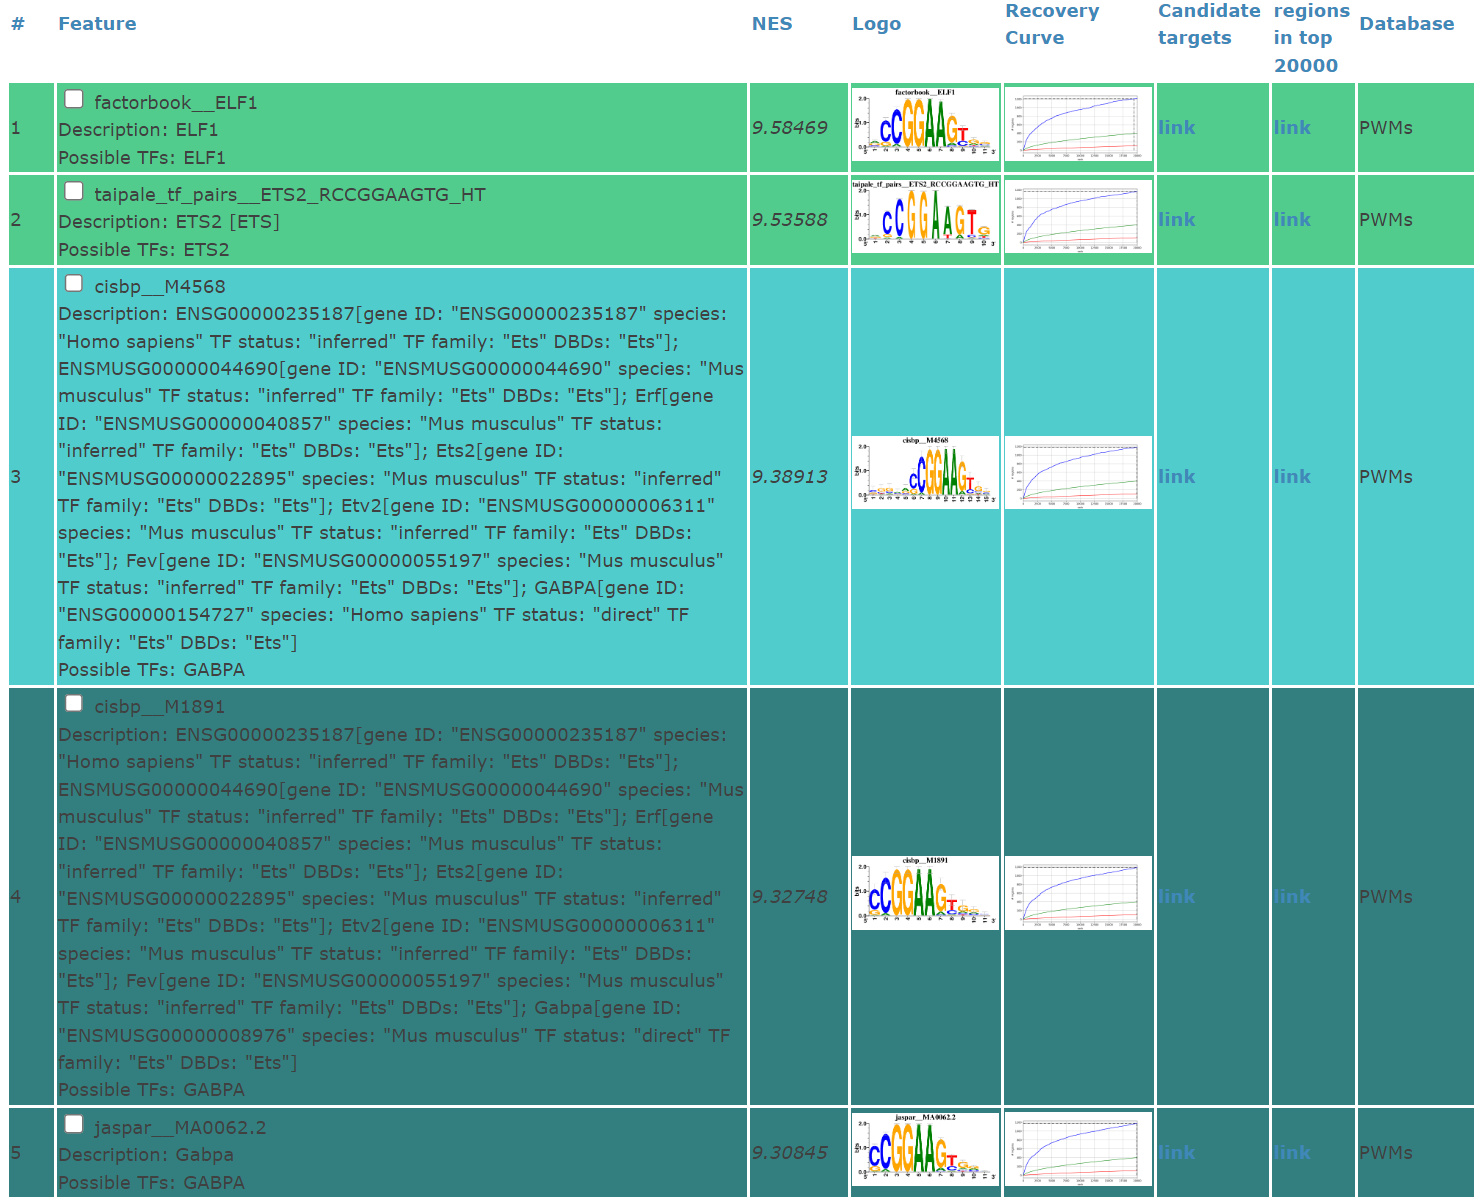

Take a look into ETS2 TFs in the ranking list above, after downloading the candidate target genes, we can see 1168 locations of these target genes of ETS2 TFs. This implies the leading edge of 1168 over the total input peaks of motif 17 (3411).

In [67]:
cat candidate_ETS2.targets.bed | head

track name=taipale_tf_pairs__ETS2_RCCGGAAGTG_HT_candidate_targets description="" useScore=1
chr4	55853427	55853777	chr4:55853427-55853777
chr2	216498645	216498995	chr2:216498645-216498995
chr7	157336751	157337100	chr7:157336751-157337100
chr5	6378441	6378791	chr5:6378441-6378791
chr5	159262944	159263294	chr5:159262944-159263294
chr3	185825537	185825744	chr3:185825537-185825744
chr6	34889062	34889411	chr6:34889062-34889411
chr3	52287898	52288163	chr3:52287898-52288163
chr7	87152274	87152622	chr7:87152274-87152622


In [68]:
cat candidate_ETS2.targets.bed | wc -l

1168


# Link peaks to genes <a name="link"></a>

Using GREAT to find genes in the region of 200kb around the peaks. A list of biological processes of the involved genes can be found. Adjust to 50 kb and download the nearby genes that associate to the peaks. As the result, there are roughly 10 000 genes associates to both direct and indirect peaks. We can find one of the genes that links to the peak in the IGV like SPAG8.

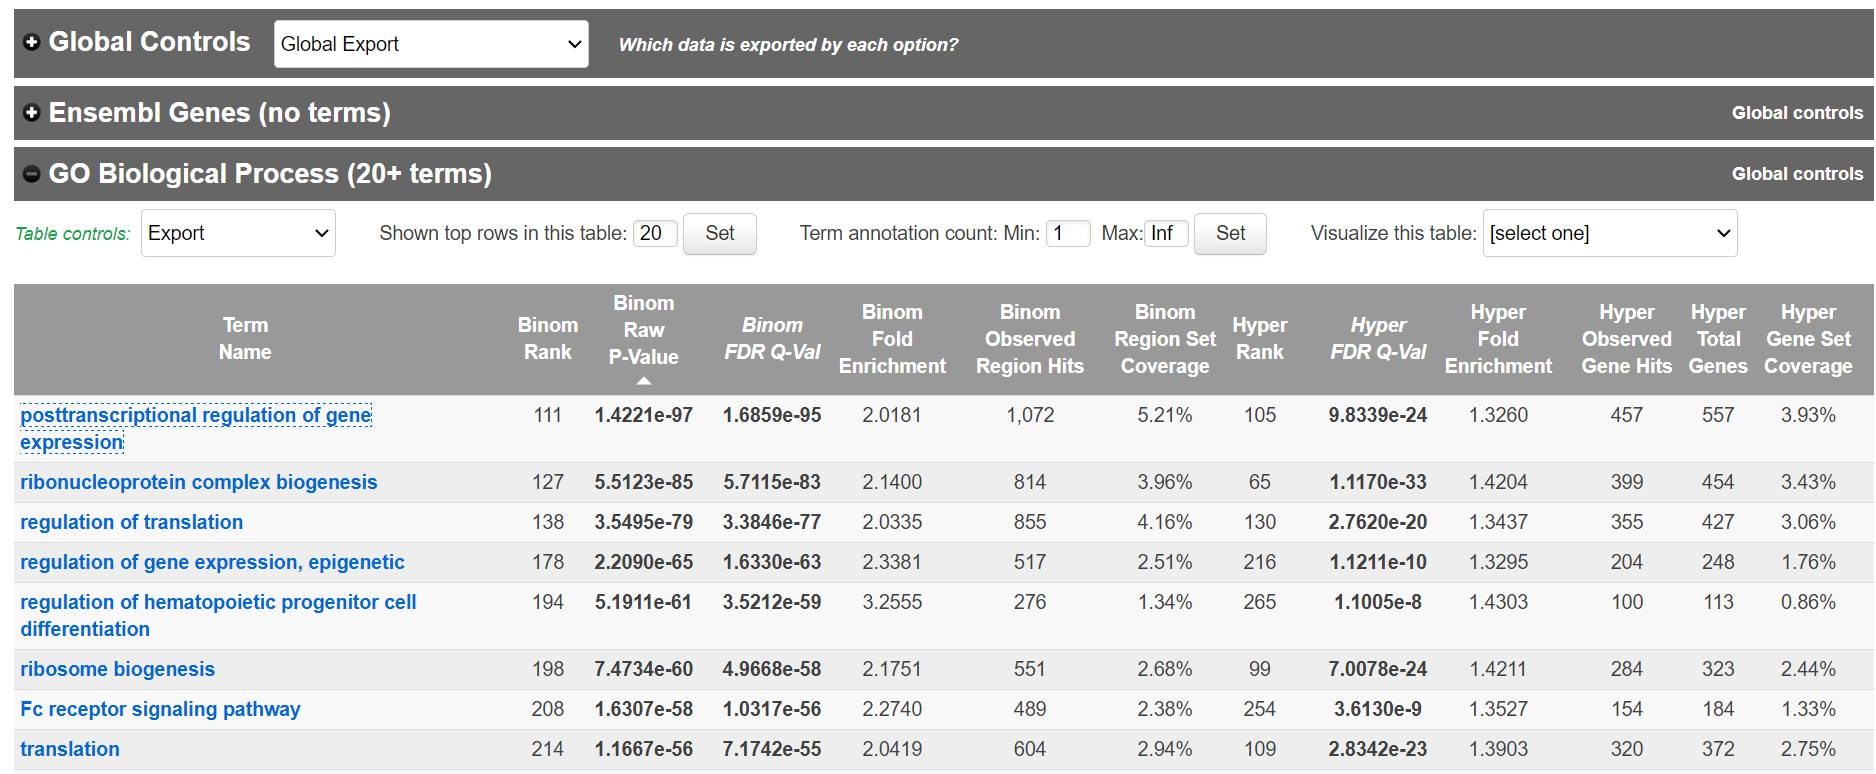

In [70]:
head hg38-all-gene.txt

# GREAT version 4.0.4	Species assembly: hg38	Association rule: Basal+extension: 5000 bp upstream, 1000 bp downstream, 50000 bp max extension, curated regulatory domains included
A1BG	unnamed (-3282), unnamed (-2626)
A3GALT2	unnamed (-29168)
A4GALT	unnamed (+45256)
AAAS	unnamed (-3152), unnamed (+92)
AAED1	unnamed (-31660), unnamed (+290)
AAGAB	unnamed (+237)
AAK1	unnamed (-747), unnamed (-221)
AAMDC	unnamed (-1282), unnamed (-546)
AAMP	unnamed (-49)


In [71]:
cat hg38-all-gene.txt | cut -f 1 | grep -v '#' | wc -l

10734


In [75]:
cat hg38-all-gene.txt | cut -f 1 | grep -v '#' | grep SPAG8

SPAG8


In [76]:
cat hg38-all-gene.txt | cut -f 1 | grep -v '#' > ETS1-targets-GREAT.txt

## Comparison of predicted targets with functional associations to ETS1 <a name="ets1"></a>

Obtaining a network of 300 associated genes with ETS1, based on genetic interactions, physical interactions, co-expression.

In [83]:
cat string_protein_annotations.tsv | cut -f1 | head

#node
ACTB
AGO1
AGO3
AGO4
AKT1
ALX1
AR
ATP2A3
BACH2


In [84]:
cat string_protein_annotations.tsv | cut -f 1 | grep -v '#' > ets1-string-top50.txt

In [85]:
list=`cat ets1-string-top50.txt`

In [86]:
for i in $list; do grep -w $i ETS1-targets-GREAT.txt; done

ACTB
AGO3
ATP2A3
BACH2
BANF1
BATF
BCL11B
BMP2
BRCA1
CBFA2T3
CBFB
CBL
CCND1
CD3D
CD3E
CD4
CD44
CD8A
CDH5
CDKN1A
CDKN2A
CDKN3
CEBPA
CEBPB
CFDP1
CREB1
CREBBP
CTCF
CTNNB1
CXCR4
DAXX
DNMT1
DUSP4
DUSP6
E2F1
E2F2
E2F3
EGR1
EOMES
EP300
EPAS1
ETS1
EWSR1
FLI1
FLT1
FOS
FOXA1
FOXD3
FOXN2
FOXO1
FOXP1
FOXP3
GABPA
GAPDH
GATA2
GATA3
GATA4
GFI1
GFI1B
GTF3C1
HDAC1
HIF1A
HMBS
HSPB1
ID1
ID2
IER2
IER5
IFNG
IKZF1
IKZF3
IRF1
IRF4
IRF8
ITGA3
JUN
JUNB
JUND
KAT2B
KIT
KLF2
KMT2D
KRAS
LCK
LDB1
LEF1
LMO2
MAF
MAFB
MAP2K1
MAP2K2
MAPK1
MAPK14
MAPK3
MAPK7
MCM8
MEIS1
MKI67
MOV10
MYC
MZF1
NCAM1
NCOA1
NCOA3
NCOR1
NF1
NFATC2
NFE2L2
NFIL3
NFKB1
NFKB2
NFRKB
NKX2-5
NOTCH1
PARP1
PAX2
PAX5
PIAS4
PIK3R1
PLAU
PLEC
PRDM1
PTEN
PURA
REL
RELB
RORA
RORC
RPS6KA2
RUNX1
RUNX3
S1PR1
SDHC
SERPINE1
SHH
SMAD2
SMAD3
SMAD4
SMARCA2
SNAI1
SNAI2
SP1
SP100
SP3
SPI1
SQSTM1
SREBF2
SRF
SRPRA
STAT1
STAT2
STAT3
STAT4
STAT6
SUCO
TAL1
TBP
TBX2
TBX21
TCF3
TCF7
TDP2
TFAM
TFAP2A
TFPT
TGFB1
TGFBR2
TIMP1
TLX1
TLX3
TNFAIP3
TNRC6A
TNRC6C
TP53
USF1
YY1
ZBTB7A
Z

: 1

In [87]:
for i in $list; do grep -w $i ETS1-targets-GREAT.txt; done > TARGETS.txt

: 1

# Conclusion <a name="conclusion"></a>

The TARGET.txt genes file are run via iRegulon to check for the genes that are regulated by ETS1. As we can see, GATA3 gene (which encodes for GATA3 transcription factor that is also very crucial in immune system) is regulated by ETS1. Thus, this coincide wih the conclusion in the literature as mentioned, where ETS1 serves as an upstream regulator for genes like GATA3 in later stage of NK cell development.

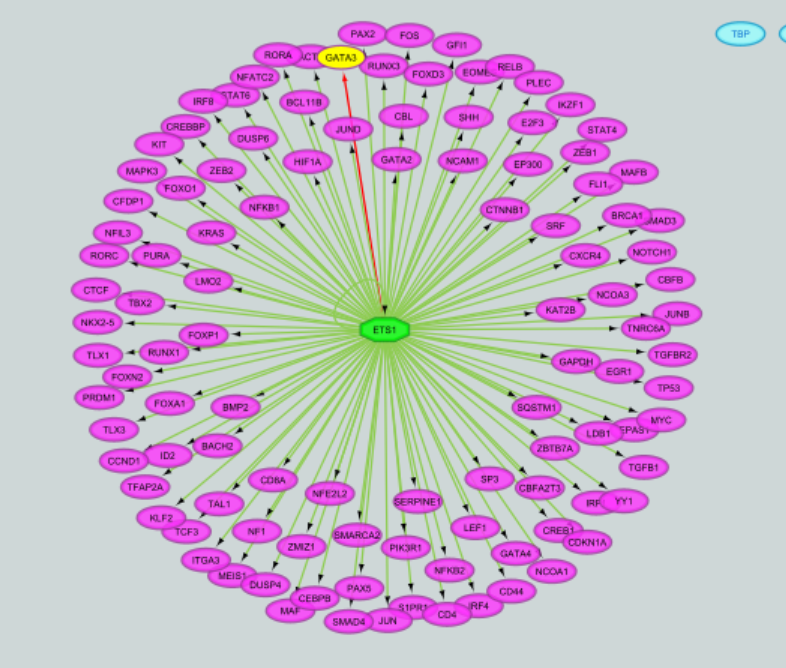